<a href="https://colab.research.google.com/github/Nram94/simulacion-modelacion-python/blob/main/Semana03_SimluacionDinamica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Simulación Dinámica**

---

## **EDOs de Primer Orden**

### **Escenario: Calentamiento de una Base de Lápiz Labial**

Una base de cera para lápiz labial ($\rho = 900 \, \text{kg/m}^3$, $C_p = 2.0 \, \text{kJ/(kg·°C)}$) se carga en un tanque de $5 \, \text{m}^3$.  
El tanque está inicialmente a $20 \, °\text{C}$. Se utiliza un serpentín de vapor para calentar el producto, manteniendo una temperatura de chaqueta constante de $150 \, °\text{C}$.  
El coeficiente de transferencia de calor general es $UA = 10 \, \text{kW/°C}$.

**Objetivo:** Determinar cuánto tiempo tarda la cera en alcanzar la temperatura de proceso de $100 \, °\text{C}$.


El producto alcanza 100.0°C en 14.36 minutos.


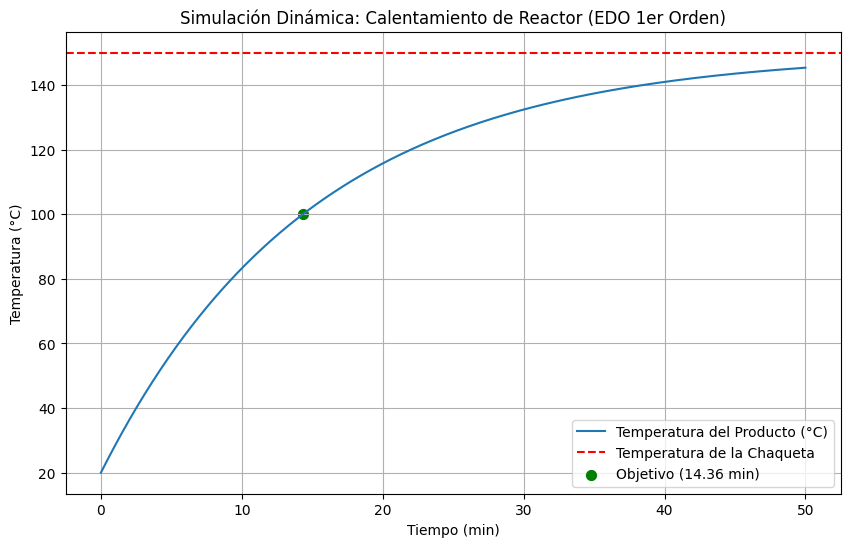

In [ ]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt


# --- 1. La Función EDO (Modelo Dinámico) ---
def modelo_calentamiento(T, t):
    # 1.1. Definir parámetros
    rho = 900.0   # Densidad (kg/m^3)
    V = 5.0       # Volumen (m^3)
    Cp = 2.0      # Capacidad calorífica (kJ/(kg*°C))
    UA = 10.0     # Coef. de transferencia de calor (kW/°C)
    Tj = 150.0    # Temperatura de la chaqueta (°C)
    M = rho * V  # Masa total (kg)
    tau = (M * Cp) / UA # Constante de tiempo del proceso

    # Ecuación: dT/dt = (1/tau) * (Tj - T)
    dTdt = (1.0 / tau) * (Tj - T)
    return dTdt


# --- 2. Definición de Parámetros ---

T_inicial = 20.0 # T(t=0)
T_final_obj = 100.0 # Objetivo


# --- 3. Solución Numérica ---
t_span = np.linspace(0, 3000, 1000) # Rango de tiempo (0 a 50 min)
T_sol = odeint(
    modelo_calentamiento,  # La función EDO
    T_inicial,             # Condición inicial
    t_span                 # Puntos de tiempo
)

# --- 4. Análisis y Visualización ---
# Encontrar el tiempo en que se alcanza la temperatura objetivo
idx = np.where(T_sol >= T_final_obj)[0][0]
t_obj = t_span[idx] /60


print(f"El producto alcanza {T_final_obj}°C en {t_obj:.2f} minutos.")
plt.figure(figsize=(10, 6))
plt.plot(t_span/60, T_sol, label='Temperatura del Producto (°C)')
plt.axhline(150, color='red', linestyle='--', label='Temperatura de la Chaqueta')
plt.scatter(t_obj, T_final_obj, color='green', s=50, label=f'Objetivo ({t_obj:.2f} min)')
plt.title("Simulación Dinámica: Calentamiento de Reactor (EDO 1er Orden)")
plt.xlabel("Tiempo (min)")
plt.ylabel("Temperatura (°C)")
plt.legend()
plt.grid(True)
plt.show()


## **Sistema de EDOs Acopladas (Orden Superior + Primer Orden)**

### **Escenario: Neutralización Exotérmica en Reactor Semi-Batch**

Se realiza una neutralización exotérmica en un reactor donde la **Concentración del ácido** ($C_A$) y la **Temperatura** ($T$) están acopladas:

- La **velocidad de reacción** (y, por tanto, $\dfrac{dC_A}{dt}$) depende de la temperatura (cinética de Arrhenius).  
- La **velocidad de calentamiento** (y, por tanto, $\dfrac{dT}{dt}$) depende del calor liberado por la reacción.  

**Variables del Sistema:**  
$\displaystyle \mathbf{y} = \begin{bmatrix} C_A \\ T \end{bmatrix}$


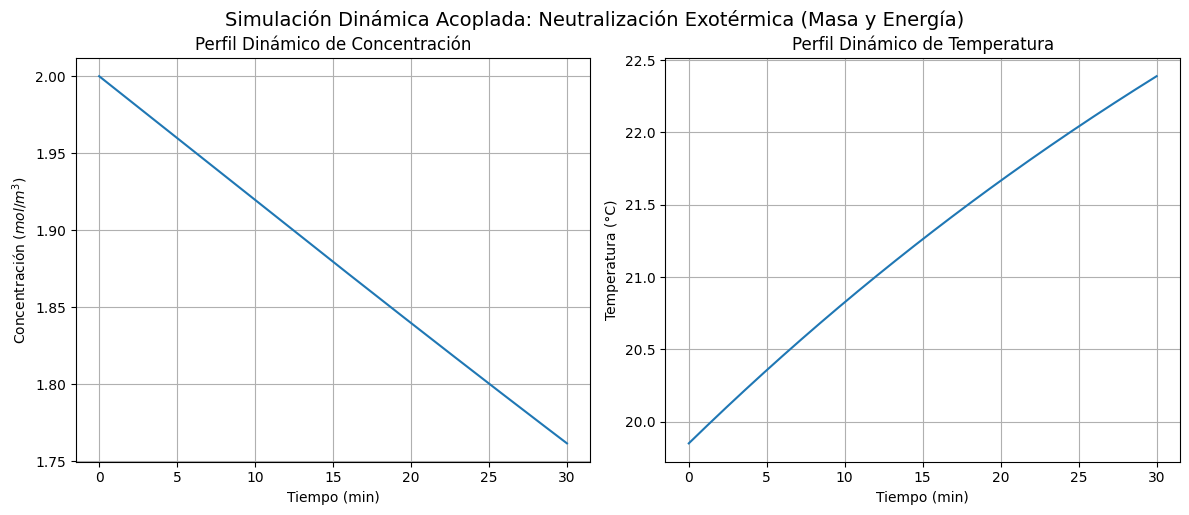

In [ ]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt


# --- 1. La Función del Sistema de EDOs ---
def modelo_reactor(y, t):
  # --- 1.1 Parámetros del Sistema ---
  # Cinética
  k0 = 1.0e8     # Factor pre-exponencial (m^3/(mol*min))
  E = 60000.0    # Energía de activación (J/mol)
  R = 8.314      # Constante de los gases (J/(mol*K))
  DeltaH = -50000.0 # Calor de reacción (J/mol) (Exotérmica)

  # Propiedades del reactor y fluido
  rho = 1000.0   # Densidad (kg/m^3)
  Cp = 4000.0    # Capacidad calorífica (J/(kg*K))
  UA = 1000.0    # Coef. de transferencia de calor total (W/K)
  V = 1.0        # Volumen (m^3)
  Tj = 300.0     # Temperatura de la chaqueta (K)
  # y = [CA, T]
  CA, T = y[0], y[1]


  # Constante cinética (Arrhenius)
  k = k0 * np.exp(-E / (R * T))

  # Velocidad de reacción
  rA = k * CA**2

  # EDO 1: dCA/dt (Balance de Masa)
  dCAdt = -rA

  # EDO 2: dT/dt (Balance de Energía)
  # Conversión de unidades: DeltaH/Cp/rho debe estar en (K/(mol/m^3))
  # Vamos a usar Watts (W) = J/s. Como el tiempo está en minutos, debemos ajustar.
  # Convertiremos todo a J/min para coherencia.
  Min_a_Seg = 60.0

  # Calor generado por reacción
  Qgen = -DeltaH * rA * V # (J/mol) * (mol/m^3/min) * m^3 = J/min

  # Calor transferido (UA debe estar en J/(min*K))
  UA_min = UA * Min_a_Seg # W * 60 = J/(min*K)
  Qperdida = UA_min * (T - Tj)

  # Acumulación de energía
  M = rho * V # kg
  dE = Qgen - Qperdida
  dTdt = dE / (M * Cp)

  return [dCAdt, dTdt]

# --- 2. Solución Numérica ---
# Condiciones iniciales: [CA0, T0]
y0 = [2.0, 293.0] # 2.0 mol/m^3, 20°C (293 K)

t_span = np.linspace(0, 30, 200) # Simular por 30 minutos

solucion_acoplada = odeint(
    modelo_reactor,
    y0,
    t_span
)

CA_sol = solucion_acoplada[:, 0]
T_sol = solucion_acoplada[:, 1] - 273.15 # Convertir a °C para visualización

# --- 3. Visualización ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(t_span, CA_sol, label='Concentración de Ácido $C_A$')
plt.title("Perfil Dinámico de Concentración")
plt.xlabel("Tiempo (min)")
plt.ylabel("Concentración ($mol/m^3$)")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(t_span, T_sol, label='Temperatura del Producto $T$')
plt.title("Perfil Dinámico de Temperatura")
plt.xlabel("Tiempo (min)")
plt.ylabel("Temperatura (°C)")
plt.grid(True)

plt.tight_layout()
plt.suptitle("Simulación Dinámica Acoplada: Neutralización Exotérmica (Masa y Energía)", y=1.02, fontsize=14)
plt.show()

## **Sistema DAE**

### **Escenario: Secado y Pérdida de Solvente Volátil (Equilibrio Instantáneo)**

Un producto (ej. esmalte de uñas, que contiene un solvente volátil **S**) se seca en un horno.  
La **masa total de solvente** ($M_S$) disminuye con el tiempo (EDO), pero la **presión de vapor parcial** ($P_S$) de ese solvente se asume que está en **equilibrio instantáneo** con la masa que queda  
(**Ecuación Algebraica:** Ley de Raoult simplificada).

---

### **Variables:**

- **$M_S$:** Masa de solvente en el producto *(kg)* — **(Diferencial)**  
- **$P_S$:** Presión parcial de vapor de *S* sobre el producto *(kPa)* — **(Algebraica)**


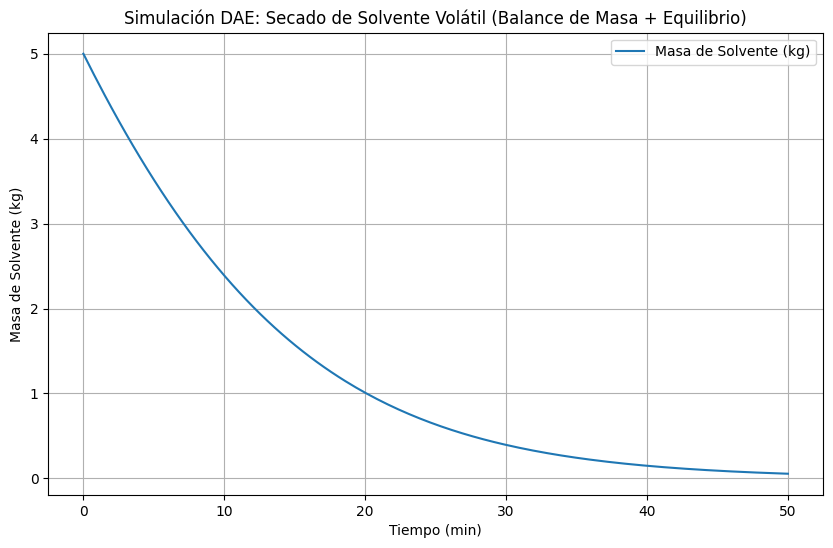

In [ ]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt


# --- 1. La Función EDO (DESPUÉS de Sustituir el Álgebra) ---
def modelo_secado_DAE(Ms, t, M_producto_seco, MW_solvente, MW_seco):
    # --- 1.1. Parámetros del Sistema DAE ---

    P_sat = 20.0            # Presión de vapor pura del solvente (kPa)
    k_transfer = 0.05       # Coef. de transferencia de masa (kg/(kPa*min))


    # 1.2 Ecuación ALGEBRAICA (Cálculo Instantáneo de la Fracción Molar xs)
    # Moles del solvente (Ns) y del producto seco (Nsec)
    Ns = Ms / MW_solvente
    Nsec = M_producto_seco / MW_seco

    # Fracción molar del solvente (xs)
    xs = Ns / (Ns + Nsec)

    # 1.3 Ecuación ALGEBRAICA (Cálculo Instantáneo de la Presión Ps)
    Ps = P_sat * xs

    # 1.4 Ecuación DIFERENCIAL (Balance de Masa)
    dMsdt = -k_transfer * Ps

    # Esta es la EDO que SciPy puede resolver:
    return dMsdt


# --- 2. Solución Numérica ---
MW_solvente = 0.1       # Peso molecular del solvente (kg/mol)
MW_seco = 0.5           # Peso molecular promedio del producto seco (kg/mol)
Ms_inicial = 5.0 # 5 kg de solvente al inicio
M_producto_seco = 50.0  # Masa del producto seco (kg)

t_span = np.linspace(0, 50, 200) # Simular por 50 minutos
args = (M_producto_seco, MW_solvente, MW_seco)

Ms_sol = odeint(
    modelo_secado_DAE,
    Ms_inicial,
    t_span,
    args=args
)

# --- 3. Análisis y Visualización ---
Ms_sol = Ms_sol.flatten()
xs_sol = (Ms_sol / MW_solvente) / ((Ms_sol / MW_solvente) + (M_producto_seco / MW_seco))

plt.figure(figsize=(10, 6))
plt.plot(t_span, Ms_sol, label='Masa de Solvente (kg)')
plt.title("Simulación DAE: Secado de Solvente Volátil (Balance de Masa + Equilibrio)")
plt.xlabel("Tiempo (min)")
plt.ylabel("Masa de Solvente (kg)")
plt.legend()
plt.grid(True)
plt.show()